# Dependencies

In [1]:
# Import all my dependencies
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plot
%matplotlib inline

In [172]:
import numpy as np
import pandas as pd
import datetime

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, asc , desc, and_
from sqlalchemy import inspect
from sqlalchemy.sql import func
from sqlalchemy import extract

In [4]:
import pymysql
pymysql.install_as_MySQLdb()

# SETUP

In [5]:
# SETUP:
# 1. establish connection to the engine (db) [5 steps]
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# 2. Declare a Base using automap_base()
# reflects the tables found into classes  
Base = automap_base()

In [7]:
# 3. Reflect the tables by calling prepare() 
Base.prepare(engine, reflect=True)

In [8]:
# 4. Create a session and connect to engine
# our access to querying data in our classes(tables)
session = Session(engine)

In [9]:
# ACCESS:
# 5. Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [10]:
# 6. Save mapping to Classes as variables 
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# 7. Call the inspector to return, table's names, columns with their data types
# optional
inspector = inspect(engine)

names = inspector.get_table_names()
print(names)

for one in inspector.get_columns('measurement'):
    print(one['name'], one['type'] )

print('---------------')
for o in inspector.get_columns('station'):
    print(o['name'], o['type'] )

['measurement', 'station']
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
---------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Precipitation Analysis

## Vacation Dates : July 1 -15

In [12]:
# 1. Design a query to retrieve the last 12 months of precipitation data and plot the results:

# First query data and get last date 
for prec in session.query(Measurement.date).order_by(desc(Measurement.date)).limit(3).all():
    print(prec)

('2017-08-23',)
('2017-08-23',)
('2017-08-23',)


In [13]:
# Query 12 months for precipitation
prec = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').order_by(desc(Measurement.date))

In [14]:
# 2. Save as Pandas DataFrame 
df = pd.read_sql(prec.statement, session.bind)
precdf = df.dropna().sort_values(['date']).groupby(['date']).count()
precdata = df.dropna().sort_values(['date']).set_index('date')

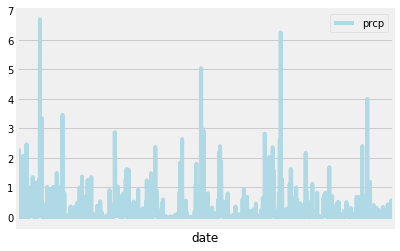

In [15]:
# 3 .Use Pandas Plotting with Matplotlib to plot the data 
plot_prcp = precdata.plot(color='lightblue', alpha=0.95)
plot.xticks([])
plot.xlabel("date")
plot.legend(loc=0)
plot.show(plot_prcp)

In [16]:
# 4. Get the summary statistics for the precipitation data
precdata.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [17]:
# 5. Query total number of stations using func.count (3 methods)

# for one in session.query(func.count(Station.station)).all():
#     print(one)

# session.query(func.count(Station.station)).first()

session.query(Station).count()

9

In [18]:
# 6. Design a query to find the most active station(s)
topStation = session.query(Measurement.station, func.count(Measurement.tobs).label('total')).group_by(Measurement.station).order_by(desc('total')).first()

# Design a query to get the name of the station
topname = session.query(Station.name).filter(Station.station == "USC00519281").first()

# Calculate the low ,high, and avg temp for the most active station
temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()

print(f"The most active station in Hawaii is {topStation[0]}, with {topStation[1]} total number of observations recorded and located at {topname[0]}.")
print("----------------------------------------------------------------")
print(f"Min temp: {temps[0]}")
print(f"Max temp: {temps[1]}")
print(f"Avg temp: {temps[2]}")

The most active station in Hawaii is USC00519281, with 2772 total number of observations recorded and located at WAIHEE 837.5, HI US.
----------------------------------------------------------------
Min temp: 54.0
Max temp: 85.0
Avg temp: 71.66378066378067


In [19]:
# 7. Choose the station with the highest number of tobs 
#  query the last 12 months of temp obs
pstation = session.query(Measurement.tobs, Measurement.date).filter(Measurement.station == 'USC00519281').filter(Measurement.date <= '2017-08-23').\
        filter(Measurement.date >= '2016-08-23')

In [20]:
# 8. Save query as Df  
tempdf = pd.read_sql(pstation.statement, session.bind)
tempdf.sort_values('tobs')
tempdf.describe()

,tobs
count,352.000000
mean,73.107955
std,4.733315
min,59.000000
25%,70.000000
50%,74.000000
75%,77.000000
max,83.000000


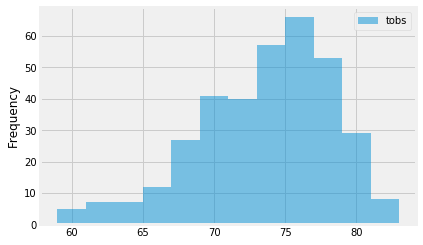

In [21]:
# 9. Plot histogram, bins=12
popular_station = plot.hist(tempdf['tobs'], bins=12, alpha=0.5)
plot.ylabel("Frequency")
plot.legend(["tobs"])
plot.show(popular_station)

# Temperature Analysis for my Trip : </br> 07-01-2017 to 01-15-2017

In [95]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """
    Args:
        start_date (string): A date string in the format 'YYYY-mm-dd'
        end_date (string): A date string in the format 'YYYY-mm-dd'
        
    Returns: Tuple
        MinTemp, MaxTemp, AveTemp 
    """
    startDate = start_date    
    endDate = end_date
        
    calcTemp = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(and_(Measurement.date >= start_date, Measurement.date <= end_date)).all()
                                                      
    return calcTemp                                       
    
# call fucntion and used for loop to obtain each element inside the 'return' tuple  
for reslt in calc_temps('2017-07-01', '2017-07-15'):
    print("Here are your Trip's Temperature Results!")
    print(f" Min temp : {reslt[0]}")
    print(f" Avg Temp : {reslt[1]}")
    print(f" Max temp : {reslt[2]}")

Here are your Trip's Temperature Results!
 Min temp : 69.0
 Avg Temp : 78.25
 Max temp : 87.0


In [94]:
from matplotlib.pyplot import figure

In [100]:
# created a lambda fucnt to calculate the peak to peak (tmax-tmin))
peak2peak = lambda x, y: y-x
abc = peak2peak(reslt[0], reslt[2] )

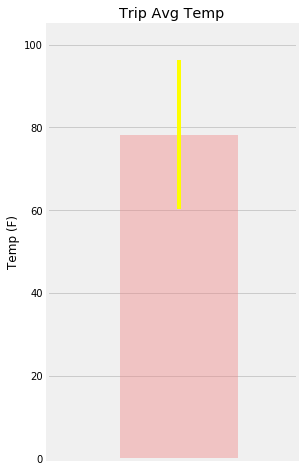

In [110]:
# 13. plot the results from your previous query as a bar chart. 
#     Use "Trip Avg Temp" as your Title
#     Use the average temperature for the y value
#     Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
#       Error bars are graphical representations of the variability of data and used on graphs to indicate the error or uncertainty in a reported measurement. 
#       They give a general idea of how precise a measurement is,
#       or conversely, how far from the reported value the true (error free) value might be.
#        Error bars that represent the 95% confidence interval (CI) of a mean are wider than SE error bars 



mean = reslt[1]
peak2peak = abc
ind = 1    # the x locations for the groups

plot.figure(figsize=(4,8))
plot.xticks([])

plot.title("Trip Avg Temp")
plot.ylabel("Temp (F)")
plot.xlim(.10 , 1.8)
plot.ylim(0,105)

mytrip_temp = plot.bar(ind, mean, yerr=peak2peak, color='lightcoral', ecolor="yellow", align="center", alpha=0.4)

# Rainfall per Weather Station for Trip

In [167]:
# 14. Is it going to rain during my trip in several parts of Hawaii? 
#session.query(Measurement.date, Measurement.prcp, Measurement.station).filter(Measurement.date >= '2016-08-23').order_by(desc(Measurement.date)).all()

print("Total calculated rainfall from July 1-15, 2017 per weather station")
print("--------------------------------------") 
for tolrainf in session.query(func.sum(Measurement.prcp), Measurement.station, Station.name).filter(Measurement.station == Station.station).filter(and_(Measurement.date >= '2017-07-01', Measurement.date <= '2017-07-15')).order_by(desc(Measurement.prcp)).group_by(Measurement.station):
    print (f" {tolrainf[1]} : {tolrainf[0]} | Location : {tolrainf[2]}" )

Total calculated rainfall from July 1-15, 2017 per weather station
--------------------------------------
 USC00516128 : 2.8700000000000006 | Location : MANOA LYON ARBO 785.2, HI US  
 USC00519281 : 1.6400000000000001 | Location : WAIHEE 837.5, HI US  
 USC00513117 : 0.8300000000000001 | Location : KANEOHE 838.1, HI US  
 USC00519397 : 0.21 | Location : WAIKIKI 717.2, HI US  
 USC00514830 : 0.39 | Location : KUALOA RANCH HEADQUARTERS 886.9, HI US  
 USC00517948 : None | Location : PEARL CITY, HI US  
 USC00519523 : 0.13 | Location : WAIMANALO EXPERIMENTAL FARM, HI US  


## Daily Normals for My Trip
* OPTChall

In [191]:
# 15. Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = (func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).first()

# testing
daily_normals("07-01")

(67.0, 74.77777777777777, 81.0)

In [203]:
# 16. use fuction to create a range of specific dates
start = datetime.datetime.strptime("07-01", "%m-%d")
end = datetime.datetime.strptime("07-15", "%m-%d")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

myTripDates = []

for date in date_generated:
    myTripDates.append(date.strftime("%m-%d"))  
    
print(myTripDates)

['07-01', '07-02', '07-03', '07-04', '07-05', '07-06', '07-07', '07-08', '07-09', '07-10', '07-11', '07-12', '07-13', '07-14']


In [200]:
# A. created a for loop that runs through date_list, 
# B. pulls each "day" and plugs it in def daily_normals(),
# C. appends each return of (min, avg, max temp) into new tuple list 

dailyNorm = []

for day in myTripDates:
    dailyNorm.append(daily_normals(day))
    
print(f" Daily Normals for my Trip : {dailyNorm} ")

 Daily Normals for my Trip : [(67.0, 74.77777777777777, 81.0), (68.0, 75.40384615384616, 82.0), (68.0, 75.32075471698113, 87.0), (70.0, 76.57142857142857, 81.0), (66.0, 75.0, 81.0), (69.0, 75.0, 81.0), (69.0, 74.91071428571429, 82.0), (69.0, 76.08333333333333, 83.0), (68.0, 76.19298245614036, 83.0), (68.0, 75.62068965517241, 82.0), (70.0, 75.78947368421052, 81.0), (67.0, 75.96491228070175, 82.0), (69.0, 76.1896551724138, 81.0), (61.0, 76.2280701754386, 82.0)] 


In [223]:
# 18. Save as Pandas DF

datesdf = pd.DataFrame(myTripDates, columns=['Dates'])

In [209]:
normalsdf = pd.DataFrame(dailyNorm, columns=['Min', 'Average', 'Max'])

In [225]:
dfDaily = pd.concat([datesdf, normalsdf], axis = 1)
dfDaily.set_index('Dates')

,Min,Average,Max
Dates,,,
07-01,67.0,74.777778,81.0
07-02,68.0,75.403846,82.0
07-03,68.0,75.320755,87.0
07-04,70.0,76.571429,81.0
07-05,66.0,75.000000,81.0
07-06,69.0,75.000000,81.0
07-07,69.0,74.910714,82.0
07-08,69.0,76.083333,83.0
07-09,68.0,76.192982,83.0


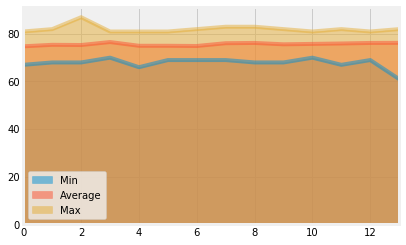

In [227]:
# 19. Plot Daily Normals for Trip
DailyPlot = dfDaily.plot.area(stacked=False)